# Data Preprozessing
Vorbereiten der Rohen input daten (Bilder, Labels sowie Numärischer input) zur späteren einfachen verwendung im Maschine learning Modell


In [ ]:
# Importieren der Bibliotheken
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
from PIL import Image
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

!pip install pvlib
import pvlib


# Anderen path einfügen
from google.colab import drive, files
drive.mount('/content/drive')


BASE_file_path = '/content/drive/My Drive/BA'


image_file_path = "/content/drive/My Drive/BA/Raw_Dataset/"
label_file_path = "/content/drive/My Drive/BA/Raw_Dataset/PV_data_ready_6_till_18.csv"

print("Setup complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 4.3 MB/s eta 0:00:00
Mounted at /content/drive
Setup complete!


# 1. Definieren von Funktionen zur Daten Verarbeitung

In [ ]:
###################################################
# Funktionen zum Laden und Preprozessen der Daten #
###################################################
def load_raw_data_from_pickle(image_file_path, label_file_path):
    if not (os.path.exists(image_file_path) and os.path.exists(label_file_path)):
        raise FileNotFoundError(f"Die Dateien {image_file_path} und {label_file_path} existieren nicht.")

    images = []
    datetime_images = []
    path_dt = os.path.join(image_file_path, "datetime_images.pkl")
    path_image = os.path.join(image_file_path, "images.pkl")

    # Load images from pickle file
    with open(path_dt, 'rb') as dt:
        datetime_images = pickle.load(dt)
    with open(path_image, 'rb') as image_file:
        images = pickle.load(image_file)

    # Convert datetime_images to datetime objects
    datetime_list_labels = [pd.to_datetime(dt_str, format='%Y-%m-%d %H:%M') for dt_str in datetime_images]

    label_data = pd.read_csv(label_file_path)

    label_data['Time'] = pd.to_datetime(label_data['Time'], format='%Y-%m-%d %H:%M')
    # label_data['Time'] = [ts.floor('min') for ts in label_data['Time']]
    label_values = label_data['PV_output_kw'].values
    datetime_list_labels = label_data['Time'].tolist()
    # Konvertierung der Timestamp-Objekte in datetime-Objekte
    datetime_list = [timestamp.to_pydatetime() for timestamp in datetime_list_labels]

    print_shapes_generic(
        image_tensors=np.array(images),
        label_values=np.array(label_values),
        datetime_list_images=datetime_images,
        datetime_list_labels=datetime_list_labels
    )

    # Entfernen von Daten zwischen 6-7 und 17-18 Uhr
    label_values, datetime_list_labels = remove_data_between_hours(label_values, datetime_list_labels)

    # Ausgabe der Shapes nach der Verarbeitung
    print_shapes_generic(
        label_values_filtered=label_values,
        datetime_list_labels_filtered=datetime_list_labels,
    )

    return np.array(images), np.array(label_values), datetime_images, datetime_list_labels



def remove_data_between_hours(label_values, datetime_list_labels):
    """
    Remove data from 6-7 and 17-18 o clock....
    """
    # Erstellen eines DataFrames für die einfachere Handhabung der Zeitstempel
    df = pd.DataFrame({'Label': label_values, 'Datetime': datetime_list_labels})

    # Extrahieren der Stunden aus den Zeitstempeln
    df['Hour'] = df['Datetime'].dt.hour

    # Filtern der Datenpunkte zwischen 6:00 und 6:59 Uhr sowie zwischen 17:01 und 18:00 Uhr
    mask = ~((df['Hour'] >= 6) & (df['Hour'] <= 6) | (df['Hour'] >= 17) & (df['Hour'] <= 18))
    df_filtered = df[mask]

    # Extrahieren der verbleibenden Daten
    label_values_filtered = df_filtered['Label'].values
    datetime_list_labels_filtered = df_filtered['Datetime'].tolist()

    return label_values_filtered, datetime_list_labels_filtered


######################################################################################################################
# Ungenutzt
def read_data_from_hdf5(file_path):
    """
    Liest Bilder, Labels und zugehörige Datumsinformationen aus separaten HDF5-Dateien.

    Parameters:
    - file_path (str): Der Pfad zu den HDF5-Dateien ohne Dateiendung (z.B. 'data_preprozessed').

    Returns:
    tuple: Ein Tupel, das Bilder, Label-Werte, Datumsinformationen für Bilder und Datumsinformationen für Labels enthält.
    """
    # Überprüfen Sie, ob die Dateipfade existieren
    image_file_path = file_path + '_Image_data_preprozessed.h5'
    label_file_path = file_path + '_Label_data_preprozessed.h5'

    if not (os.path.exists(image_file_path) and os.path.exists(label_file_path)):
        raise FileNotFoundError(f"Die Dateien {image_file_path} und {label_file_path} existieren nicht.")

    # Öffnen Sie die HDF5-Dateien im Lesemodus
    with h5py.File(image_file_path, 'r') as hf_images, \
         h5py.File(label_file_path, 'r') as hf_labels:

        # Lesen Sie Bilder und zugehörige Datumsinformationen aus der Image HDF5-Datei
        images = [np.array(hf_images['images'][f'image_{i}']) for i in range(len(hf_images['images']))]
        datetime_list_images = [datetime.strptime(dt.decode('utf-8'), '%Y-%m-%d %H:%M:%S')
                                for dt in hf_images['datetime_images']]

        # Lesen Sie Labels und zugehörige Datumsinformationen aus der Label HDF5-Datei
        labels = [np.array(hf_labels['labels'][f'label_{i}']) for i in range(len(hf_labels['labels']))]
        datetime_list_labels = [datetime.strptime(dt.decode('utf-8'), '%Y-%m-%d %H:%M:%S')
                                for dt in hf_labels['datetime_labels']]

    return np.array(images), np.array(labels), np.array(datetime_list_images), np.array(datetime_list_labels)


def load_raw_data(image_file_path, label_file_path, small_data_set=True):
    """
    Eine Funktion zum Laden von Raw Bilddaten und Label-Daten und PRE preprozessing.

    Parameters:
    image_file_path (str): Der Pfad zum Hauptordner, der die Tagesordner enthält.
    label_file_path (str): Der Pfad zur CSV-Datei mit den Label-Daten.
    small_data_set (bool): Gibt an, ob nur die ersten 5 Tagesordner eingelesen werden sollen.

    Returns:
    image_tensors -- Ein NumPy-Array von Bildern
    label_data -- Ein NumPy-Array mit den Label-Daten aus den CSV-Dateien
    datetime_list_images -- Eine Liste von DateTime-Objekten der Bilder
    """

    if not os.path.exists(image_file_path) or not os.path.exists(label_file_path):
        raise FileNotFoundError("Der angegebene Bild- oder Label-Pfad existiert nicht.")

    datetime_list_images = []

    # Wenn small_data_set=True, dann entweder nur die ersten 5 Tagesordner oder alle Tagesordner einlesen
    if small_data_set:
        day_folders = sorted([f for f in os.listdir(image_file_path) if os.path.isdir(os.path.join(image_file_path, f))])[:1]
    else:
        day_folders = sorted([f for f in os.listdir(image_file_path) if os.path.isdir(os.path.join(image_file_path, f))])

    if not day_folders:
        raise ValueError("Es wurden keine Tagesordner gefunden.")

    image_npArray = []
    for day_folder in day_folders:
        day_folder_path = os.path.join(image_file_path, day_folder)
        image_files = sorted([f for f in os.listdir(day_folder_path) if f.endswith('.jpg')])
        image_paths = [os.path.join(day_folder_path, filename) for filename in image_files]

        if not image_paths:
            print(f"Warnung: Keine Bilder im Ordner {day_folder_path}")

        # Bilder in NumPy-Arrays konvertieren und in eine Liste speichern
        for filename in image_paths:
            img = Image.open(filename)
            img_array = np.array(img)
            image_npArray.append(img_array)

            # Konvertiere den String in ein DateTime-Objekt und füge es zur Liste hinzu
            name_without_extension = os.path.splitext(filename)[0]
            name_without_extension = name_without_extension.split(os.sep)[-1]
            date_time_obj = datetime.strptime(name_without_extension, '%Y%m%d%H%M%S')
            datetime_list_images.append(date_time_obj)

    if not image_npArray:
        raise ValueError("Es wurden keine Bilder gefunden.")

    # Liste der NumPy-Arrays in ein NumPy-Array konvertieren
    image_tensors = np.array(image_npArray)

    # Überprüfen, ob der label_file_path existiert
    if not os.path.exists(label_file_path):
        raise FileNotFoundError("Der angegebene Label-Pfad existiert nicht.")

    # Lade Label-Daten aus der CSV-Datei
    label_data = pd.read_csv(label_file_path)
    label_data['Time'] = pd.to_datetime(label_data['Time'])

    if small_data_set:
        mask = label_data['Time'].isin(datetime_list_images)
        label_data = label_data[mask]

    label_values = label_data['PV_output_kw'].values
    datetime_list_labels = label_data['Time'].tolist()

    print_shapes_generic(image_tensors=image_tensors,
                 label_values=label_values,
                 datetime_list_images=datetime_list_images,
                 datetime_list_labels= datetime_list_labels)

    return image_tensors, label_values, datetime_list_images, datetime_list_labels


def save_data_to_hdf5(file_path, image_tensors, label_values, datetime_list_images, datetime_list_labels):
    """
    Speichert Bilder, Label und zugehörige Datumsinformationen in separaten HDF5-Dateien.

    Parameters:
    - file_path (str): Der Pfad zur HDF5-Datei ohne Dateiendung (z.B. 'data_preprozessed').
    - image_tensors (list): Eine Liste von NumPy-Arrays, die die Bilder repräsentieren.
    - label_values (list): Eine Liste von NumPy-Arrays, die die Label-Werte repräsentieren.
    - datetime_list_images (list): Eine Liste von Datetime-Objekten, die die zugehörigen Zeitstempel für Bilder repräsentieren.
    - datetime_list_labels (list): Eine Liste von Datetime-Objekten, die die zugehörigen Zeitstempel für Labels repräsentieren.
    """
    # Überprüfen Sie, ob die Anzahl der Bilder und Datumsinformationen übereinstimmt
    if len(image_tensors) != len(datetime_list_images) or len(label_values) != len(datetime_list_labels):
        raise ValueError("Die Anzahl der Bilder und Datumsinformationen muss übereinstimmen.")

    # Überprüfen Sie, ob der Dateipfad existiert, andernfalls erstellen Sie das Verzeichnis
    if not os.path.exists(os.path.dirname(file_path)):
        os.makedirs(os.path.dirname(file_path))

    # Öffnen Sie die HDF5-Dateien im Schreibmodus
    with h5py.File(file_path + '_Image_data_preprozessed.h5', 'w') as hf_images, \
         h5py.File(file_path + '_Label_data_preprozessed.h5', 'w') as hf_labels:

        # Erstellen Sie Gruppen für Bilder und Datumsinformationen in den HDF5-Dateien
        img_group = hf_images.create_group('images')
        datetime_group_images = hf_images.create_group('datetime_images')

        label_group = hf_labels.create_group('labels')
        datetime_group_labels = hf_labels.create_group('datetime_labels')

        # Speichern Sie jedes Bild und zugehörige Datumsinformation in der Image HDF5-Datei
        for i, (img, dt_img) in enumerate(zip(image_tensors, datetime_list_images)):
            img_group.create_dataset(f'image_{i}', data=img)
            datetime_group_images.create_dataset(f'datetime_{i}', data=np.string_(dt_img.strftime('%Y-%m-%d %H:%M:%S')))

        # Speichern Sie jedes Label und zugehörige Datumsinformation in der Label HDF5-Datei
        for i, (label, dt_label) in enumerate(zip(label_values, datetime_list_labels)):
            label_group.create_dataset(f'label_{i}', data=label)
            datetime_group_labels.create_dataset(f'datetime_{i}', data=np.string_(dt_label.strftime('%Y-%m-%d %H:%M:%S')))
######################################################################################################################


def Test_Data_for_missing(datetime_list_images, datetime_list_labels):
    """
    Kontrolliert, ob zu jedem Bild ein Label existiert und umgekehrt.
    """
    set_images = set(datetime_list_images)
    set_labels = set(datetime_list_labels)

    images_missing_labels = set_images - set_labels
    labels_missing_images = set_labels - set_images

    print("Fehlende Labels zu Bildern:")
    if images_missing_labels:
        print(len(list(images_missing_labels)))
    else:
        print("Keine fehlenden Labels zu Bildern gefunden.")

    print("\nFehlende Bilder zu Labels:")
    if labels_missing_images:
        print(len(list(labels_missing_images)))
    else:
        print("Keine fehlenden Bilder zu Labels gefunden.")

    return list(images_missing_labels), list(labels_missing_images)



def delete_missing_data(image_tensors, label_values, datetime_list_images, datetime_list_labels, images_missing_labels, labels_missing_images):
    """
    Löscht fehlende Einträge zwischen Bildern und Labels.
    """

    # Konvertiere die Listen zu NumPy-Arrays für effizientere Operationen
    datetime_list_images = np.array(datetime_list_images)
    datetime_list_labels = np.array(datetime_list_labels)

    # Erstelle Masken für die zu löschenden Elemente
    mask_images = np.isin(datetime_list_images, images_missing_labels)
    mask_labels = np.isin(datetime_list_labels, labels_missing_images)

    # Wende die Masken auf die Arrays an, um die Elemente zu entfernen
    datetime_list_images = datetime_list_images[~mask_images]
    image_tensors = np.delete(image_tensors, np.where(mask_images), axis=0)

    datetime_list_labels = datetime_list_labels[~mask_labels]
    label_values = np.delete(label_values, np.where(mask_labels))

    print_shapes_generic(
    image_tensors=image_tensors,
    label_values=label_values,
    datetime_list_images=datetime_list_images,
    datetime_list_labels=datetime_list_labels
    )
    return image_tensors, label_values, datetime_list_images.tolist(), datetime_list_labels.tolist()


def get_shape(obj):
    if isinstance(obj, np.ndarray):
        return obj.shape
    elif isinstance(obj, list):
        return len(obj)
    else:
        return "N/A"

def print_shapes_kwargs(**kwargs):
    for name, value in kwargs.items():
        print(f"Variable: {name}, Shape/Length: {get_shape(value)}")


def Preprocess_Data_for_Prediction(image_tensors, label_values, datetime_list_images, datetime_list_labels, prediction_time=15):
    """
    Diese Funktion verschiebt die Label-Daten und Zeitstempel um die angegebene Vorhersagezeit.
    """

    if prediction_time == 0:  # Für Nowcast
        prediction_labels = label_values
        prediction_datetime_labels = datetime_list_labels
        prediction_images = image_tensors
        prediction_datetime_images = datetime_list_images
    else:
        # Verschiebe label_values und datetime_list_labels um prediction_time nach vorne
        prediction_labels = label_values[prediction_time:]
        prediction_datetime_labels = datetime_list_labels[prediction_time:]

        # Entferne die letzten prediction_time Elemente aus image_tensors und datetime_list_images
        prediction_images = image_tensors[:-prediction_time]
        prediction_datetime_images = datetime_list_images[:-prediction_time]

    print_shapes_generic(image_tensors=image_tensors,
                 label_values=label_values,
                 datetime_list_images=datetime_list_images,
                 datetime_list_labels= datetime_list_labels)

    return prediction_images, prediction_labels, prediction_datetime_images, prediction_datetime_labels

def print_shapes_generic(**data_dict):
    for key, value in data_dict.items():
        if isinstance(value, list):
            print(f"{key} Length: {len(value)}")
        elif isinstance(value, np.ndarray):
            print(f"{key} Shape: {value.shape}")
        else:
            print(f"{key} Type: {type(value)}")


def to_grayscale(images):
    """
    Konvertiert eine Liste von RGB-Bildern in Graustufenbilder.
    """
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    # Konvertiere die Bilder in Graustufen
    grayscale_images = tf.image.rgb_to_grayscale(images)

    # Konvertiere Tensor zurück in ein NumPy-Array
    grayscale_images = grayscale_images.numpy()

    # Ausgabe der Shapes
    print(f"Shapes von grayscale_images: {grayscale_images.shape}")

    return grayscale_images


def resize_images(images, target_height, target_width):
    """
    Vergrößert Bilder auf eine Zielgröße.

    Parameter:
    images (numpy.ndarray): Numpy-Array der Form (num_images, height, width, channels).
    target_height (int): Zielhöhe für die Vergrößerung.
    target_width (int): Zielbreite für die Vergrößerung.

    Rückgabe:
    numpy.ndarray: Numpy-Array der vergrößerten Bilder mit der Form (num_images, target_height, target_width, channels).
    """
    num_images, height, width, channels = images.shape

    # Überprüfe auf gültige Werte für target_height und target_width
    if target_height <= 0 or target_width <= 0:
        raise ValueError("target_height and target_width must be greater than 0")

    # Initialisiere das Array für die vergrößerten Bilder
    resized_images = np.empty((num_images, target_height, target_width, channels), dtype=np.uint8)

    # Vergrößere jedes Bild auf die Zielgröße
    for i in range(num_images):
        # Überprüfe auf nicht leere Bilder, bevor du resize durchführst
        if not np.any(images[i]):
            raise ValueError(f"Image at index {i} is empty and cannot be resized")

        resized_image = cv2.resize(images[i], (target_width, target_height))

        # Füge den gewünschten Kanal hinzu, wenn das Originalbild nur einen Kanal hat
        if channels == 1:
            resized_image = np.expand_dims(resized_image, axis=-1)

        resized_images[i] = resized_image

    return resized_images




def normalize_and_split_data(image_tensors, label_values, datetime_list_images, datetime_list_labels, Normalisierung=True, zero_centering=False,
                              train_split=0.7, validation_split=0.15, random_seed=None):
    """
    Teilt die Eingabedaten in Trainings-, Validierungs- und Testsets auf und normalisiert die Daten.

    Parameters:
    ... (unchanged)
    train_split : float, optional, default: 0.7
        Anteil der Daten für das Trainingsset.
    validation_split : float, optional, default: 0.15
        Anteil der Daten für das Validierungsset.
    random_seed : int or None, optional, default: None
        Der Zufallsseed für die Aufteilung der Daten.

    Returns:
    tuple: Vier Tupel bestehend aus Trainings- und Testdaten für Bilder und Labels.
    """

    # Bilder und Labels in Numpy-Arrays und in Float32 konvertieren, falls noch nicht geschehen
    if not isinstance(image_tensors, np.ndarray):
        image_tensors = np.array(image_tensors, dtype=np.float32)
    if not isinstance(label_values, np.ndarray):
        label_values = np.array(label_values, dtype=np.float32)

    # Konvertierung der Label-Werte zu 'float32'
    label_values = label_values.astype(np.float32)

    # Erzeuge eine Liste mit eindeutigen Tagen
    unique_days = np.unique([date.date() for date in datetime_list_labels])

    # Zufällige Auswahl der Tage für Train, Validation und Test
    train_days, validation_days, test_days = np.split(np.random.permutation(unique_days), [int(train_split*len(unique_days)), int((train_split + validation_split)*len(unique_days))])

    # Funktion zum Überprüfen, ob ein Datum zu einem bestimmten Tag gehört
    def is_day(date, day):
        return date.date() == day

    # Filtere die Daten für Train, Validation und Test
    train_indices = [i for i, date in enumerate(datetime_list_labels) if any(is_day(date, day) for day in train_days)]
    validation_indices = [i for i, date in enumerate(datetime_list_labels) if any(is_day(date, day) for day in validation_days)]
    test_indices = [i for i, date in enumerate(datetime_list_labels) if any(is_day(date, day) for day in test_days)]

    images_train, labels_train, datetime_train = image_tensors[train_indices], label_values[train_indices], [datetime_list_labels[i] for i in train_indices]
    images_validation, labels_validation, datetime_validation = image_tensors[validation_indices], label_values[validation_indices], [datetime_list_labels[i] for i in validation_indices]
    images_test, labels_test, datetime_test = image_tensors[test_indices], label_values[test_indices], [datetime_list_labels[i] for i in test_indices]

    if Normalisierung:
        # Normalisierung der Bilder durch Teilung durch 255
        images_train = images_train.astype(np.float32) / 255.0
        images_validation = images_validation.astype(np.float32) / 255.0
        images_test = images_test.astype(np.float32) / 255.0

    if zero_centering:
        # Zero-Centering der Bilder
        images_train -= np.mean(images_train, axis=(0, 1, 2), keepdims=True)
        images_validation -= np.mean(images_validation, axis=(0, 1, 2), keepdims=True)
        images_test -= np.mean(images_test, axis=(0, 1, 2), keepdims=True)

    # Ausgabe der Shapes nach der Verarbeitung
    print_shapes_generic(
        images_train=images_train,
        images_validation=images_validation,
        images_test=images_test,
        labels_train=labels_train,
        labels_validation=labels_validation,
        labels_test=labels_test,
        datetime_train=datetime_train,
        datetime_validation=datetime_validation,
        datetime_test=datetime_test,
        datetime_list_train=[datetime_list_labels[i] for i in train_indices],
        datetime_list_validation=[datetime_list_labels[i] for i in validation_indices],
        datetime_list_test=[datetime_list_labels[i] for i in test_indices]
    )

    return images_train, images_validation, images_test, labels_train, labels_validation, labels_test, \
           datetime_train, datetime_validation, datetime_test, \
           [datetime_list_labels[i] for i in train_indices], [datetime_list_labels[i] for i in validation_indices], [datetime_list_labels[i] for i in test_indices]


###############################################
# Funktionen Darstellen und Plotten der Daten #
###############################################


def print_shapes(images_train, images_validation, images_test,
                        labels_train, labels_validation, labels_test,
                        datetime_train, datetime_validation, datetime_test,
                        datetime_labels_train, datetime_labels_validation, datetime_labels_test):
    print("Trainingsdaten:")
    print("Bilder:", images_train.shape)
    print("Labels:", labels_train.shape)
    print("Datetime:", datetime_train.shape)
    print("Datetime Labels:", datetime_labels_train.shape)

    print("\nValidierungsdaten:")
    print("Bilder:", images_validation.shape)
    print("Labels:", labels_validation.shape)
    print("Datetime:", datetime_validation.shape)
    print("Datetime Labels:", datetime_labels_validation.shape)

    print("\nTestdaten:")
    print("Bilder:", images_test.shape)
    print("Labels:", labels_test.shape)
    print("Datetime:", datetime_test.shape)
    print("Datetime Labels:", datetime_labels_test.shape)


def plot_labels_by_time(labels_train, labels_validation, labels_test,
                        datetime_labels_train, datetime_labels_validation, datetime_labels_test):
    # Zusammenfügen der Daten für das Plotting
    all_labels = np.concatenate([labels_train, labels_validation, labels_test])
    all_datetimes = np.concatenate([datetime_labels_train, datetime_labels_validation, datetime_labels_test])
    all_sets = ['Train'] * len(labels_train) + ['Validation'] * len(labels_validation) + ['Test'] * len(labels_test)

    # Erstellen eines DataFrames für Seaborn
    data = {'Labels': all_labels, 'Datetime': all_datetimes, 'Set': all_sets}
    df = pd.DataFrame(data)

    # Filtere Datensätze mit fehlenden Tagen
    df = df[df['Datetime'].notna()]

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Datetime', y='Labels', hue='Set', data=df,palette={'Train': '#1f77b4', 'Validation': 'red', 'Test': 'green'})
    plt.xlabel('Datum')
    plt.ylabel('PV-Leistung [kW]')
    plt.title('PV-Leistungsdaten')
    plt.legend(loc='upper right')
    plt.xticks()#rotation=45
    plt.tight_layout()
    plt.show()



def plot_random_images_with_labels(images, labels, datetime_list_images, num_images=9):

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Random Images with Timestamps and Labels')

    # Überprüfe, ob num_images größer ist als die Anzahl der verfügbaren Bilder
    if num_images > len(images):
        num_images = len(images)
        print(f"Only {num_images} images available. Showing all images.")

    # Wähle zufällige Indizes aus
    random_indices = random.sample(range(len(images)), num_images)

    for i, ax in enumerate(axes.flatten()):
        if i < len(random_indices):
            index = random_indices[i]
            image = images[index]
            label = labels[index]
            timestamp = datetime_list_images[index]

            # Zeige das Bild an
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f"Timestamp: {timestamp}\n PV Power: {round(label,3)} kW")
        else:
            ax.axis('off')  # Leere Plots ausblenden

    plt.tight_layout()
    plt.show()


def plot_label_distribution(labels_train, labels_validation, labels_test):
    plt.figure(figsize=(8, 6))
    plt.hist(labels_train, bins=50, alpha=0.5, label='Train Labels')
    plt.hist(labels_validation, bins=50, alpha=0.5, label='Validation Labels')
    plt.hist(labels_test, bins=50, alpha=0.5, label='Test Labels')
    plt.xlabel('Label Values')
    plt.ylabel('Frequency')
    plt.title('Label Distribution')
    plt.legend()
    plt.show()


def save_data_by_category(images_train, images_validation, images_test,
                          labels_train, labels_validation, labels_test,
                          datetime_train, datetime_validation, datetime_test,
                          datetime_labels_train, datetime_labels_validation, datetime_labels_test,
                          save_folder):
    # Erstelle die Unterordner
    train_folder = os.path.join(save_folder, 'Train data')
    validation_folder = os.path.join(save_folder, 'Validation data')
    test_folder = os.path.join(save_folder, 'Test data')
    for folder in [train_folder, validation_folder, test_folder]:
        os.makedirs(folder, exist_ok=True)

    # Speichere die Trainingsdaten
    train_data_dict = {
        'images_train': images_train,
        'labels_train': labels_train,
        'datetime_train': datetime_train,
        'datetime_labels_train': datetime_labels_train
    }
    for key, value in train_data_dict.items():
        file_path = os.path.join(train_folder, f"{key}.pkl")
        with open(file_path, 'wb') as f:
            pickle.dump(value, f)

    # Speichere die Validierungsdaten
    validation_data_dict = {
        'images_validation': images_validation,
        'labels_validation': labels_validation,
        'datetime_validation': datetime_validation,
        'datetime_labels_validation': datetime_labels_validation
    }
    for key, value in validation_data_dict.items():
        file_path = os.path.join(validation_folder, f"{key}.pkl")
        with open(file_path, 'wb') as f:
            pickle.dump(value, f)

    # Speichere die Testdaten
    test_data_dict = {
        'images_test': images_test,
        'labels_test': labels_test,
        'datetime_test': datetime_test,
        'datetime_labels_test': datetime_labels_test
    }
    for key, value in test_data_dict.items():
        file_path = os.path.join(test_folder, f"{key}.pkl")
        with open(file_path, 'wb') as f:
            pickle.dump(value, f)

    print(f"Data saved in Train, Validation, and Test data folders in {save_folder}")


###############################################
# Funktionen für Data Augmentation erstellung #
###############################################


def apply_data_augmentation(images, augmentation_type='invert', threshold=251, clip_limit=2.0, brightness_factor=1.5, contrast_factor=1.5):
    """
    Führt Data Augmentation auf einem Bildarray durch.

    Parameters:
    images (numpy.ndarray): Eingabe-Bildarray mit Shape (N, H, W, C), wobei N die Anzahl der Bilder ist und H, W, C die Dimensionen eines Bildes sind.
    augmentation_type (str): Art der Data Augmentation. Mögliche Werte: 'invert', 'clahe', 'brightness', 'contrast'.
    threshold (int): Schwellenwert für die Umkehrung von Pixelwerten (nur für 'invert').
    clip_limit (float): Grenzwert für CLAHE (nur für 'clahe').
    brightness_factor (float): Faktor für die Helligkeitsanpassung (nur für 'brightness').
    contrast_factor (float): Faktor für die Kontrastanpassung (nur für 'contrast').

    Returns:
    numpy.ndarray: Bildarray nach der Data Augmentation.
    """
    augmented_images = []

    for i in range(len(images)):
        image = images[i]

        if augmentation_type == 'invert':
            # Führe die Schwellenwertumkehrung nur für Pixelwerte über dem Schwellenwert durch
            mask = image > threshold
            inverted_pixels = cv2.bitwise_not(image[mask])
            # Überprüfe, ob inverted_pixels nicht None und nicht leer ist
            if inverted_pixels is not None and inverted_pixels.size > 0:
                image[mask] = inverted_pixels
            augmented_image = image


        elif augmentation_type == 'clahe':
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
            augmented_image = clahe.apply(gray)
        elif augmentation_type == 'brightness':
            augmented_image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)
        elif augmentation_type == 'contrast':
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            hsv[..., 2] = np.clip(hsv[..., 2] * contrast_factor, 0, 255)
            augmented_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        else:
            raise ValueError("Invalid augmentation_type. Choose from 'invert', 'clahe', 'brightness', 'contrast'.")

        augmented_images.append(augmented_image)

    return np.array(augmented_images)



def visualize_augmented_images(original_images, augmented_images):
    """
    Visualisiert Original- und augmentierte Bilder.

    Parameters:
    original_images (numpy.ndarray): Array mit Originalbildern.
    augmented_images (numpy.ndarray): Array mit augmentierten Bildern.

    Returns:
    None
    """
    num_images = len(original_images)

    # Zufällig ausgewählte Indizes für die Darstellung
    indices = np.random.choice(num_images, size=3, replace=False)

    for index in indices:
        # Originalbild
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original_images[index])
        plt.title('Original')
        plt.axis('off')

        # Augmentiertes Bild
        plt.subplot(1, 2, 2)
        plt.imshow(augmented_images[index])
        plt.title('Augmented')
        plt.axis('off')

        plt.show()


###########################################
# Funktionen für Image Sequenz erstellung #
###########################################

def transform_images_array(images_array1, images_array2, images_array3, step=5, num_previous=2):
    """
    Diese Funktion nimmt drei Bilder-Arrays mit unterschiedlichen Formen und erweitert sie, indem sie das aktuelle Bild und die vorherigen Bilder entsprechend den angegebenen Parametern anhängt. Anschließend werden die Bilder in den bestehenden Farbkanälen gestapelt.

    Parameters:
    images_array1 (numpy.ndarray): Das erste Bilder-Array.
    images_array2 (numpy.ndarray): Das zweite Bilder-Array.
    images_array3 (numpy.ndarray): Das dritte Bilder-Array.
    step (int): Die Schrittweite zwischen den vorherigen Bildern.
    num_previous (int): Die Anzahl der vorherigen Bilder, die angehängt werden sollen.

    Returns:
    tuple: Drei Tupel bestehend aus den transformierten Arrays für das erste, zweite und dritte Bild.
    """
    # Erstellen von leeren Arrays für die Ergebnisse
    result_array1 = []
    result_array2 = []
    result_array3 = []

    # Überprüfen der Form des ersten Arrays und Ermitteln der Dimensionen
    num_samples1, img_height, img_width, channels1 = images_array1.shape
    num_samples2, img_height, img_width, channels2 = images_array2.shape
    num_samples3, img_height, img_width, channels3 = images_array3.shape

    # Anhängen des aktuellen Bildes und der vorherigen Bilder
    for i in range(num_previous, num_samples1):
        stacked_images = np.dstack([images_array1[i - j * step] for j in range(num_previous + 1)])
        result_array1.append(stacked_images)

    # Anhängen des aktuellen Bildes und der vorherigen Bilder
    for i in range(num_previous, num_samples2):
        stacked_images = np.dstack([images_array2[i - j * step] for j in range(num_previous + 1)])
        result_array2.append(stacked_images)

    # Anhängen des aktuellen Bildes und der vorherigen Bilder
    for i in range(num_previous, num_samples3):
        stacked_images = np.dstack([images_array3[i - j * step] for j in range(num_previous + 1)])
        result_array3.append(stacked_images)

    # Konvertieren der Listen in NumPy-Arrays
    result_array1 = np.array(result_array1)
    result_array2 = np.array(result_array2)
    result_array3 = np.array(result_array3)

    return result_array1, result_array2, result_array3



def save_images_as_pickles(folder_path, **image_arrays):
    """
    Speichert die übergebenen Bild-Arrays in einzelnen Pickle-Dateien mit den Parameternamen als Dateinamen.

    Parameters:
    folder_path (str): Der Pfad zum Ordner, in dem die Pickle-Dateien gespeichert werden sollen.
    **image_arrays: Beliebig viele Bild-Arrays, die gespeichert werden sollen. Der Parametename wird als Dateiname verwendet.

    Returns:
    None
    """
    # Erstellen des Ordners, falls nicht vorhanden
    os.makedirs(folder_path, exist_ok=True)

    for param_name, image_array in image_arrays.items():
        file_path = os.path.join(folder_path, f"{param_name}.pkl")
        with open(file_path, 'wb') as file:
            pickle.dump(image_array, file)


def create_image_sequences(train_images, val_images, test_images, previous_images=5):
    """
    Erstellt Sequenzen von Bildern aus den gegebenen Trainings-, Validierungs- und Testbildern.

    Parameters:
    train_images (numpy.ndarray): Das Trainingsbild-Array.
    val_images (numpy.ndarray): Das Validierungsbild-Array.
    test_images (numpy.ndarray): Das Testbild-Array.
    previous_images (int): Die Anzahl der vorherigen Bilder in jeder Sequenz.

    Returns:
    tuple: Drei Tupel mit den erstellten Bildsequenzen für Trainings-, Validierungs- und Testdaten.
    """
    def create_sequences(images, num_previous_images):
        sequences = []
        for i in range(num_previous_images, len(images)):
            sequence = [images[i]] + [images[i - j] for j in range(1, num_previous_images+1)]
            sequences.append(sequence)
        return np.array(sequences)

    # Erstelle Sequenzen für die Trainingsdaten
    train_image_sequences = create_sequences(train_images, previous_images)

    # Erstelle Sequenzen für die Validierungsdaten
    val_image_sequences = create_sequences(val_images, previous_images)

    # Erstelle Sequenzen für die Testdaten
    test_image_sequences = create_sequences(test_images, previous_images)

    return train_image_sequences, val_image_sequences, test_image_sequences


###############################################
# Funktionen für Smart Persistence Berechnung #
###############################################


def smart_persistence_pv_forecast(labels_train, labels_validation, labels_test,
                                  datetime_labels_train, datetime_labels_validation, datetime_labels_test):
    """
    Berechnet die Smart Persistence Predictions für Trainings-, Validierungs- und Testdaten.

    Parameters:
    labels_train (numpy.ndarray): Die Labels für Trainingsdaten.
    labels_validation (numpy.ndarray): Die Labels für Validierungsdaten.
    labels_test (numpy.ndarray): Die Labels für Testdaten.
    datetime_labels_train (list): Die Zeitstempel für Trainingsdaten.
    datetime_labels_validation (list): Die Zeitstempel für Validierungsdaten.
    datetime_labels_test (list): Die Zeitstempel für Testdaten.

    Returns:
    tuple: Drei Tupel bestehend aus Smart Persistence Predictions und zugehörigen Zeitstempeln für Trainings-,
           Validierungs- und Testdaten.
    """
    predictions_train = []
    for i, time in enumerate(datetime_labels_train):
        actual_pv_output = labels_train[i]
        smart_pred, _, _ = the_future_pv_output(time=time, actual_pv_output=actual_pv_output)
        predictions_train.append([time, np.float32(smart_pred)])

    predictions_validation = []
    for i, time in enumerate(datetime_labels_validation):
        actual_pv_output = labels_validation[i]
        smart_pred, _, _ = the_future_pv_output(time=time, actual_pv_output=actual_pv_output)
        predictions_validation.append([time, np.float32(smart_pred)])

    predictions_test = []
    for i, time in enumerate(datetime_labels_test):
        actual_pv_output = labels_test[i]
        smart_pred, _, _ = the_future_pv_output(time=time, actual_pv_output=actual_pv_output)
        predictions_test.append([time, np.float32(smart_pred)])

    return (
        pd.DataFrame(predictions_train, columns=["Time", "Smart Prediction"]),
        pd.DataFrame(predictions_validation, columns=["Time", "Smart Prediction"]),
        pd.DataFrame(predictions_test, columns=["Time", "Smart Prediction"])
    )


def the_future_pv_output(time, actual_pv_output):

    actual_clr_pv_output = calculate_clr_pv_output(date=time)
    future_clr_pv_output = calculate_clr_pv_output(date=time + pd.Timedelta(value=15, unit='minutes'))

    # Calculate the clear sky index
    k_clr = actual_pv_output / actual_clr_pv_output

    # Calculate the T-minute-ahead PV output estimation using smart persistence
    future_pv_output = k_clr * future_clr_pv_output

    return future_pv_output, future_clr_pv_output, k_clr


def calculate_clr_pv_output(date):

    sun_zenite_deg, sun_azimuth_deg = calc_sun_position(date=date)

    # Convert angles to radians
    sun_zenite_rad = np.radians(sun_zenite_deg)
    sun_azimuth_rad = np.radians(sun_azimuth_deg)
    panel_elevation_rad = np.radians(panel_elevation)
    panel_azimuth_rad = np.radians(panel_azimuth)

    pclr_t = max_solar_irradiance * effective_panel_area * (np.cos(panel_elevation_rad)* np.cos(sun_zenite_rad) + np.sin(panel_elevation_rad)* np.sin(sun_zenite_rad)* np.cos((sun_azimuth_rad-panel_azimuth_rad)))

    return pclr_t


def calc_sun_position(date: pd.Timestamp):
    # Solarposition berechnen
    solar_position = pvlib.solarposition.get_solarposition(
                                                            date,
                                                            latitude,
                                                            longitude,
                                                            altitude,
                                                            pressure=None,  # Der Luftdruck kann optional angegeben werden
                                                            method='nrel_numpy'  # Die Methode zur Berechnung der Solarposition
                                                            )

    # Extrahieren von Sonnenazimut und Elevation
    sun_azimuth = solar_position['azimuth'].values[0]  # Sonnenazimut
    sun_elevation = solar_position['elevation'].values[0]  # Sonnenhöhe (Elevation)

    return sun_elevation, sun_azimuth


def save_spm_forcast(predictions_train, predictions_validation, predictions_test, save_folder):
    """
    Speichert Smart Persistence Prognosen in Pickle-Dateien für Trainings-, Validierungs- und Testdaten.

    Parameters:
    predictions_train (pd.DataFrame): DataFrame für Trainingsdaten.
    predictions_validation (pd.DataFrame): DataFrame für Validierungsdaten.
    predictions_test (pd.DataFrame): DataFrame für Testdaten.
    save_folder (str): Der Ordner, in dem die Pickle-Dateien gespeichert werden sollen.

    Returns:
    None
    """
    os.makedirs(save_folder, exist_ok=True)

    train_filename = os.path.join(save_folder, "spm_predictions_train.pkl")
    validation_filename = os.path.join(save_folder, "spm_predictions_validation.pkl")
    test_filename = os.path.join(save_folder, "spm_predictions_test.pkl")

    with open(train_filename, 'wb') as file:
        pickle.dump(predictions_train, file)

    with open(validation_filename, 'wb') as file:
        pickle.dump(predictions_validation, file)

    with open(test_filename, 'wb') as file:
        pickle.dump(predictions_test, file)

    # Save "Time" column as a separate file
    time_train_filename = os.path.join(save_folder, "spm_predictions_time_train.pkl")
    time_validation_filename = os.path.join(save_folder, "spm_predictions_time_validation.pkl")
    time_test_filename = os.path.join(save_folder, "spm_predictions_time_test.pkl")

    with open(time_train_filename, 'wb') as file:
        pickle.dump(predictions_train['Time'], file)

    with open(time_validation_filename, 'wb') as file:
        pickle.dump(predictions_validation['Time'], file)

    with open(time_test_filename, 'wb') as file:
        pickle.dump(predictions_test['Time'], file)


##########################################
# Funktionen für Auxiliary Data Creation #
##########################################


def create_sequence_arrays(images_train, images_validation, images_test, labels_train, labels_validation, labels_test, datetime_train, datetime_validation, datetime_test, datetime_labels_train, datetime_labels_validation, datetime_labels_test, predictions_train, predictions_validation, predictions_test, num_previous_images):
    """
    Erstellt Sequenz-Arrays aus den Label-Daten.

    Parameters:
    labels_train (numpy.ndarray): Die Labels für das Training.
    labels_validation (numpy.ndarray): Die Labels für die Validierung.
    labels_test (numpy.ndarray): Die Labels für den Test.

    Returns:
    tuple: Drei Tupel bestehend aus den modifizierten Sequenz-Arrays für Trainings-, Validierungs- und Testdaten.
    """

    # Funktion zum Erstellen der Sequenz-Arrays
    def create_sequences(images, num_previous_images):
        sequences = []
        for i in range(num_previous_images, len(images)):
            sequence = [images[i]] + [images[i - j] for j in range(1, num_previous_images+1)]
            sequences.append(sequence)
        return np.array(sequences)


    # Anwenden der Funktion auf die drei Datenmengen
    sequence_labels_train = create_sequences(labels_train,num_previous_images)
    sequence_labels_validation = create_sequences(labels_validation,num_previous_images)
    sequence_labels_test = create_sequences(labels_test,num_previous_images)


    # Überall die ersten 15 elemnte entfernen, da hierfür keine sequenz daten erstellt werden konnten und die längen dennoch übereinstimmen müssen!

    labels_train = labels_train[15:]
    labels_validation = labels_validation[15:]
    labels_test = labels_test[15:]

    # Entfernen von Zeilen mit NaN-Werten aus den images
    images_train = images_train[15:]
    images_validation = images_validation[15:]
    images_test = images_test[15:]

    # Entfernen von Zeilen mit NaN-Werten aus den TimeStamps
    datetime_train = datetime_train[15:]
    datetime_validation = datetime_validation[15:]
    datetime_test = datetime_test[15:]
    datetime_labels_train = datetime_labels_train[15:]
    datetime_labels_validation = datetime_labels_validation[15:]
    datetime_labels_test = datetime_labels_test[15:]

    # Entfernen von Zeilen mit NaN-Werten aus den spm predictions
    predictions_train = predictions_train[15:]
    predictions_validation = predictions_validation[15:]
    predictions_test = predictions_test[15:]

    # Hinzufügen der Spalte "predictions" zu den Sequenz-Arrays
    sequence_labels_train = np.column_stack((sequence_labels_train, predictions_train["Smart Prediction"]))
    sequence_labels_validation = np.column_stack((sequence_labels_validation, predictions_validation["Smart Prediction"]))
    sequence_labels_test = np.column_stack((sequence_labels_test, predictions_test["Smart Prediction"]))



    return images_train, images_validation, images_test, labels_train, labels_validation, labels_test, datetime_train, datetime_validation, datetime_test, datetime_labels_train, datetime_labels_validation, datetime_labels_test, predictions_train, predictions_validation, predictions_test, sequence_labels_train, sequence_labels_validation, sequence_labels_test

def extract_hour_minute_combined_arrays(array1, array2, array3, num_previous_images=None):
    """
    Extrahiert die Stunden und Minuten aus drei Arrays von DateTime-Objekten und gibt jeweils ein kombiniertes Float32-Array zurück.

    Parameters:
    array1 (np.ndarray): Das erste Array von DateTime-Objekten.
    array2 (np.ndarray): Das zweite Array von DateTime-Objekten.
    array3 (np.ndarray): Das dritte Array von DateTime-Objekten.

    Returns:
    tuple: Drei Tupel, jedes enthält ein Array, das die Stunden und Minuten als kombinierte Fließkommawerte enthält.
    """
    combined_array1 = np.array([dt.hour + dt.minute / 100.0 for dt in array1], dtype=np.float32)
    combined_array2 = np.array([dt.hour + dt.minute / 100.0 for dt in array2], dtype=np.float32)
    combined_array3 = np.array([dt.hour + dt.minute / 100.0 for dt in array3], dtype=np.float32)

    def create_sequences(images, num_previous_images):
        if not num_previous_images:
           return images
        else:
            sequences = []
            for i in range(num_previous_images, len(images)):
                sequence = [images[i]] + [images[i - j] for j in range(1, num_previous_images+1)]
                sequences.append(sequence)
            return np.array(sequences)

    combined_array1 = create_sequences(combined_array1,num_previous_images)
    combined_array2 = create_sequences(combined_array2,num_previous_images)
    combined_array3 = create_sequences(combined_array3,num_previous_images)

    # Aufruf der print_shapes_alg Funktion
    print_shapes_alg(combined_array1, combined_array2, combined_array3)

    return combined_array1, combined_array2, combined_array3



def print_shapes_alg(*args):
    for i, arg_list in enumerate(args):
        if isinstance(arg_list, list):
            for j, arg in enumerate(arg_list):
                print(f"Shape of [{j}]: {arg.shape if hasattr(arg, 'shape') else 'Not applicable'}")
        else:
            print(f"Shape of args[{i}]: {arg_list.shape if hasattr(arg_list, 'shape') else 'Not applicable'}")

def save_data_to_pickles_generic(save_path, **kwargs):
    """
    Speichert eine variable Anzahl von Arrays im pkl-Format mit den jeweiligen Variablennamen als Dateinamen.

    Parameters:
    save_path (str): Der Pfad, in dem die Pickle-Dateien gespeichert werden sollen.
    **kwargs: Eine variable Anzahl von Arrays, die gespeichert werden sollen. Die Variablennamen werden als Dateinamen verwendet.
    """
    os.makedirs(save_path, exist_ok=True)

    for var_name, data_array in kwargs.items():
        file_path = os.path.join(save_path, f"{var_name}.pkl")
        with open(file_path, 'wb') as file:
            pickle.dump(data_array, file)
        print(f"Data saved: {file_path}")


def save_data_to_pickles(folder_path, images_train=None, images_val=None, images_test=None):
    """
    Speichert die übergebenen Daten in einzelnen Pickle-Dateien mit den Variablennamen als Dateinamen.

    Parameters:
    folder_path (str): Der Pfad zum Ordner, in dem die Pickle-Dateien gespeichert werden sollen.
    images_train (numpy.ndarray): Array für Trainingsbilder.
    images_val (numpy.ndarray): Array für Validierungsbilder.
    images_test (numpy.ndarray): Array für Testbilder.

    Returns:
    None
    """
    # Erstellen des Ordners, falls nicht vorhanden
    os.makedirs(folder_path, exist_ok=True)

    if images_train is not None:
        file_path = os.path.join(folder_path, "images_train.pkl")
        with open(file_path, 'wb') as file:
            pickle.dump(images_train, file)

    if images_val is not None:
        file_path = os.path.join(folder_path, "images_val.pkl")
        with open(file_path, 'wb') as file:
            pickle.dump(images_val, file)

    if images_test is not None:
        file_path = os.path.join(folder_path, "images_test.pkl")
        with open(file_path, 'wb') as file:
            pickle.dump(images_test, file)



def trim_data_to_min_length(images_train=[], images_validation=[], images_test=[],
                             labels_train=None, labels_validation=None, labels_test=None,
                             datetime_train=None, datetime_validation=None, datetime_test=None,
                             datetime_labels_train=None, datetime_labels_validation=None, datetime_labels_test=None,
                             predictions_train=None, predictions_validation=None, predictions_test=None,
                             sequence_labels_train=None, sequence_labels_validation=None, sequence_labels_test=None,
                             Aux_Time_train=None, Aux_Time_validation=None, Aux_Time_test=None):
    min_length_train = images_train.shape[0]
    min_length_validation = images_validation.shape[0]
    min_length_test = images_test.shape[0]

    return (Aux_Time_train[:min_length_train] if Aux_Time_train is not None else None,
           Aux_Time_validation[:min_length_validation] if Aux_Time_validation is not None else None,
           Aux_Time_test[:min_length_test] if Aux_Time_test is not None else None,
           images_train if images_train is not None else None,
           images_validation if images_validation is not None else None,
           images_test if images_test is not None else None,
           labels_train[:min_length_train] if labels_train is not None else None,
           labels_validation[:min_length_validation] if labels_validation is not None else None,
           labels_test[:min_length_test] if labels_test is not None else None,
           datetime_train[:min_length_train] if datetime_train is not None else None,
           datetime_validation[:min_length_validation] if datetime_validation is not None else None,
           datetime_test[:min_length_test] if datetime_test is not None else None,
           datetime_labels_train[:min_length_train] if datetime_labels_train is not None else None,
           datetime_labels_validation[:min_length_validation] if datetime_labels_validation is not None else None,
           datetime_labels_test[:min_length_test] if datetime_labels_test is not None else None,
           predictions_train[:min_length_train] if predictions_train is not None else None,
           predictions_validation[:min_length_validation] if predictions_validation is not None else None,
           predictions_test[:min_length_test] if predictions_test is not None else None,
           sequence_labels_train[:min_length_train] if sequence_labels_train is not None else None,
           sequence_labels_validation[:min_length_validation] if sequence_labels_validation is not None else None,
           sequence_labels_test[:min_length_test] if sequence_labels_test is not None else None,
           )






# 2. Daten Preprozessing
- Laden der Roh daten
- Korregieren von fehlenden Daten punkten
- Label zu entsprechendem Bild zuordnen (für 15min PV Forcast)
- Daten Normalisieren und in Train/Validation/Test Split aufteilen

In [ ]:
# load_raw_data
image_tensors, label_values, datetime_list_images, datetime_list_labels = load_raw_data_from_pickle(image_file_path,label_file_path)


image_tensors Shape: (41405, 224, 224, 3)
label_values Shape: (33166,)
datetime_list_images Length: 41405
datetime_list_labels Length: 33166
label_values_filtered Shape: (27600,)
datetime_list_labels_filtered Length: 27600


In [ ]:
# Test_Data_for_missing
images_missing_labels, labels_missing_images = Test_Data_for_missing(datetime_list_images, datetime_list_labels)

Fehlende Labels zu Bildern:
15186

Fehlende Bilder zu Labels:
1381


In [ ]:
# delete_missing_data
image_tensors, label_values, datetime_list_images, datetime_list_labels = delete_missing_data(image_tensors, label_values, datetime_list_images, datetime_list_labels, images_missing_labels, labels_missing_images)

image_tensors Shape: (26219, 224, 224, 3)
label_values Shape: (26219,)
datetime_list_images Shape: (26219,)
datetime_list_labels Shape: (26219,)


In [ ]:
# Preprocess_Data_for_Prediction
image_tensors, label_values, datetime_list_images, datetime_list_labels = Preprocess_Data_for_Prediction(image_tensors, label_values, datetime_list_images, datetime_list_labels, prediction_time=15)

image_tensors Shape: (26219, 224, 224, 3)
label_values Shape: (26219,)
datetime_list_images Length: 26219
datetime_list_labels Length: 26219


In [ ]:
# Optional: Hier nochmal alle bilder und label speichern, falls nötig.
#file_path = os.path.join(BASE_file_path,"/preprozessed_data/preprozessed_data_as_pkl")
"""
save_images_as_pickles(folder_path=file_path,
                  image_tensors=image_tensors,
                  label_values=label_values,
                  datetime_list_images=datetime_list_images,
                  datetime_list_labels=datetime_list_labels)"""

## Data Augmentation
Eignen Data Auqmentation Ordner mit nur den bild daten erstellen.

- **Invertieren des Bildes:**

    Diese Technik invertiert die Pixelwerte des Bildes ab einen bestimmten threshold. Dunkle Bereiche werden hell, und umgekehrt.

- **Kontrast Limited Adaptive Histogram Equalization (CLAHE):**

    CLAHE verbessert den Kontrast von Bildern, indem es die Helligkeit lokal anpasst. Es verhindert übermäßiges Aufhellen von hellen Regionen und Abdunkeln von dunklen Regionen.

- **Helligkeitsanpassung:**

    Hier wird die Helligkeit des Bildes angepasst, indem jeder Pixelwert mit einem Helligkeitsfaktor multipliziert wird. Dies erhöht oder verringert die Helligkeit des Bildes.

- **Kontrastanpassung:**

    Diese Technik passt den Kontrast des Bildes an, indem die Werte im HSV-Farbraum manipuliert werden. Der Kontrastfaktor wird auf den Helligkeitskanal angewendet.

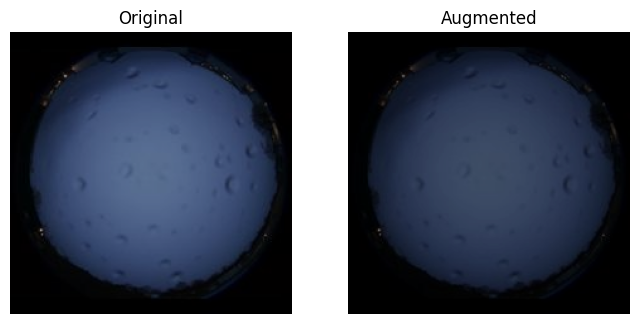

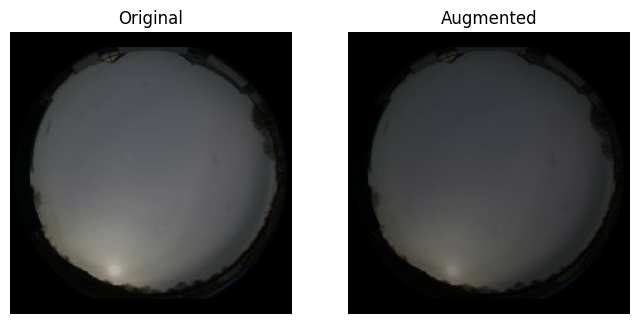

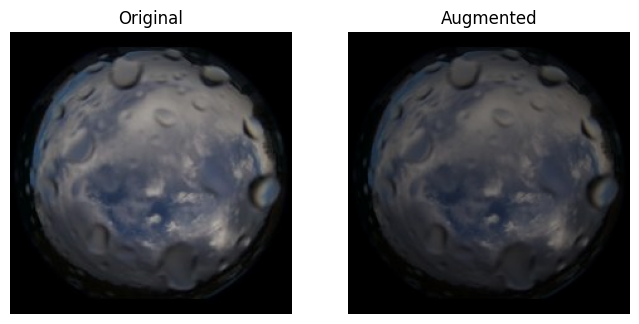

In [ ]:
# Wähle zwischen Data Augmentation: 'invert', 'clahe', 'brightness', 'contrast'

images_augmented = apply_data_augmentation( images=image_tensors,
                                            augmentation_type='contrast',
                                            threshold=150,
                                            clip_limit=2.0,
                                            brightness_factor=0.7,
                                            contrast_factor=0.7)


visualize_augmented_images(image_tensors, images_augmented)



In [ ]:
image_tensors = images_augmented

Shapes von grayscale_images: (26204, 224, 224, 1)


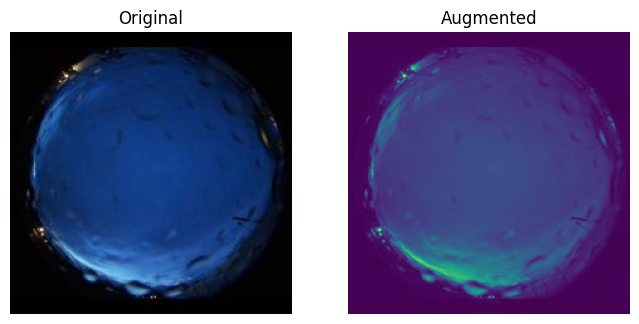

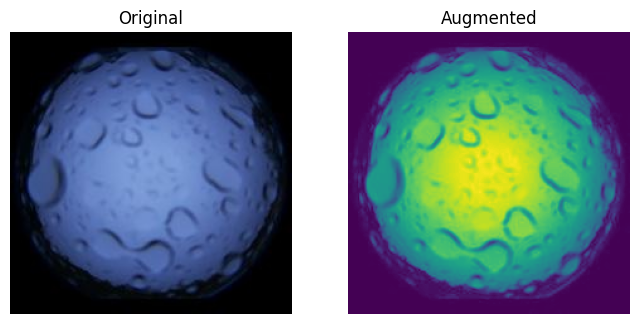

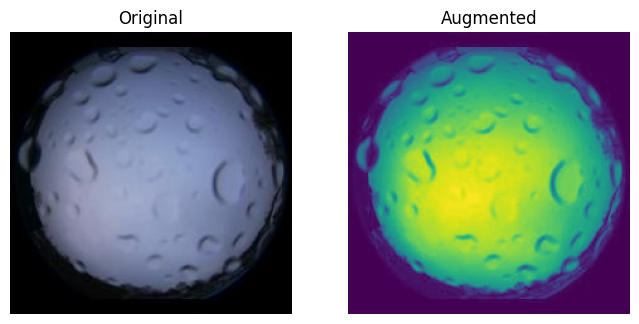

In [ ]:
# to_grayscale

image_tensors_greyscale = to_grayscale(image_tensors)

visualize_augmented_images(image_tensors, image_tensors_greyscale)

In [ ]:
image_tensors = image_tensors_greyscale

In [ ]:
image_tensors.shape

(20502, 224, 224, 1)

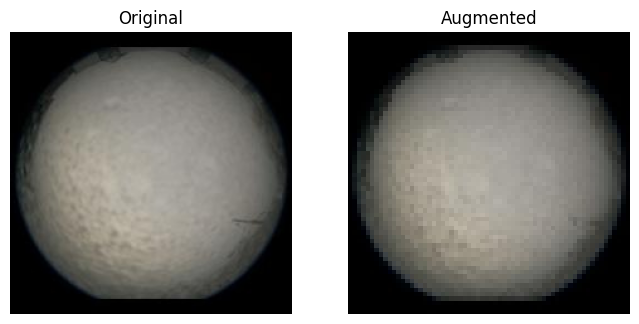

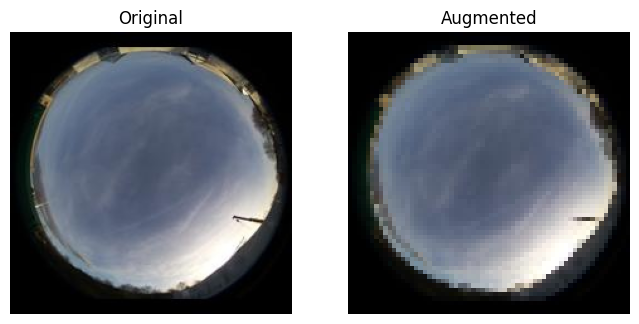

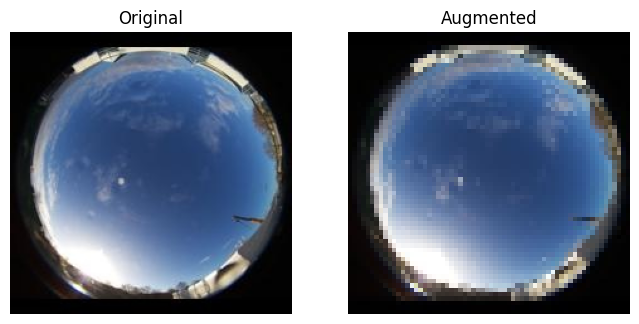

In [ ]:
# change Image size
image_tensors_croped = resize_images(image_tensors, target_height=64, target_width=64)

visualize_augmented_images(image_tensors, image_tensors_croped)

In [ ]:
image_tensors = image_tensors_croped

# Daten Normalisieren und in Train/Val/Test split aufteilen

In [ ]:
# normalize_and_split_data
# Auswahl:
Normalisierung = True
zero_centering = True


# Funktions Aufruf:
images_train, images_validation, images_test, labels_train, labels_validation, labels_test, datetime_train, datetime_validation, datetime_test, datetime_labels_train, datetime_labels_validation, datetime_labels_test = normalize_and_split_data(image_tensors, label_values, datetime_list_images, datetime_list_labels,train_split=0.7, validation_split=0.10, Normalisierung=Normalisierung, zero_centering=zero_centering)

images_train Shape: (18013, 64, 64, 3)
images_validation Shape: (2400, 64, 64, 3)
images_test Shape: (5791, 64, 64, 3)
labels_train Shape: (18013,)
labels_validation Shape: (2400,)
labels_test Shape: (5791,)
datetime_train Length: 18013
datetime_validation Length: 2400
datetime_test Length: 5791
datetime_list_train Length: 18013
datetime_list_validation Length: 2400
datetime_list_test Length: 5791


# 3. Datensatz erstellung
- Je nach gewünschter konfiguration daten satz weiter anpassen

## 3.2. Eine Bild Sequenz mit shape (224, 224, X)
!Achtung Speicherbedarf erhöt sich Drastisch!
- X = Anzahl der Bilder pro datenpunkt
- Dabei wird die letzte Dimension (RGB oder Greyscale) Kollabiert um so mehr als ein bild als input zu bekommen  
- z.b. in letzter dimension werden bilder [t, t-5, t-10] gespeichert

In [ ]:
image_sequens_train, image_sequens_validation, image_sequens_test = transform_images_array(  images_array1=images_train,
                                                                        images_array2=images_validation,
                                                                        images_array3=images_test,
                                                                        step=5,              # z.b. [t, t-5, t-10, t-15...] bei step=5
                                                                        num_previous=2)      # z.b. [t, t-5, t-10] bei num_previous=2

# Testen ob shapes passen
print_shapes_alg(image_sequens_train, image_sequens_validation, image_sequens_test)

Shape of args[0]: (20961, 64, 64, 3)
Shape of args[1]: (2946, 64, 64, 3)
Shape of args[2]: (2291, 64, 64, 3)


In [ ]:

images_train = image_sequens_train
images_validation = image_sequens_validation
images_test = image_sequens_test

## 3.3. Eine Bild Sequenz mit shape (X, 224,224, 3)
!Achtung Speicher Bedarf erhöt sich Drastisch!

- X = Anzahl der Bilder pro datenpunkt
- Es wird eine Neue Dimension hinzugefügt, so dass jeder Datenpunkt zwei oder mehr bilder enthalten kann
- für RGB und Greyscale geeignet


In [ ]:
# Erstellt eine neue dimension und packt dort das aktuelle bild (t) und bei previous_images=2 das bild (t-2) rein

image_sequens_train, image_sequens_validation, image_sequens_test = create_image_sequences(images_train,
                                                                                           images_validation,
                                                                                           images_test,
                                                                                           previous_images=15)

# Testen ob shapes passen
print_shapes_alg(image_sequens_train, image_sequens_validation, image_sequens_test)

Shape of args[0]: (18327, 16, 64, 64, 3)
Shape of args[1]: (3916, 16, 64, 64, 3)
Shape of args[2]: (3916, 16, 64, 64, 3)


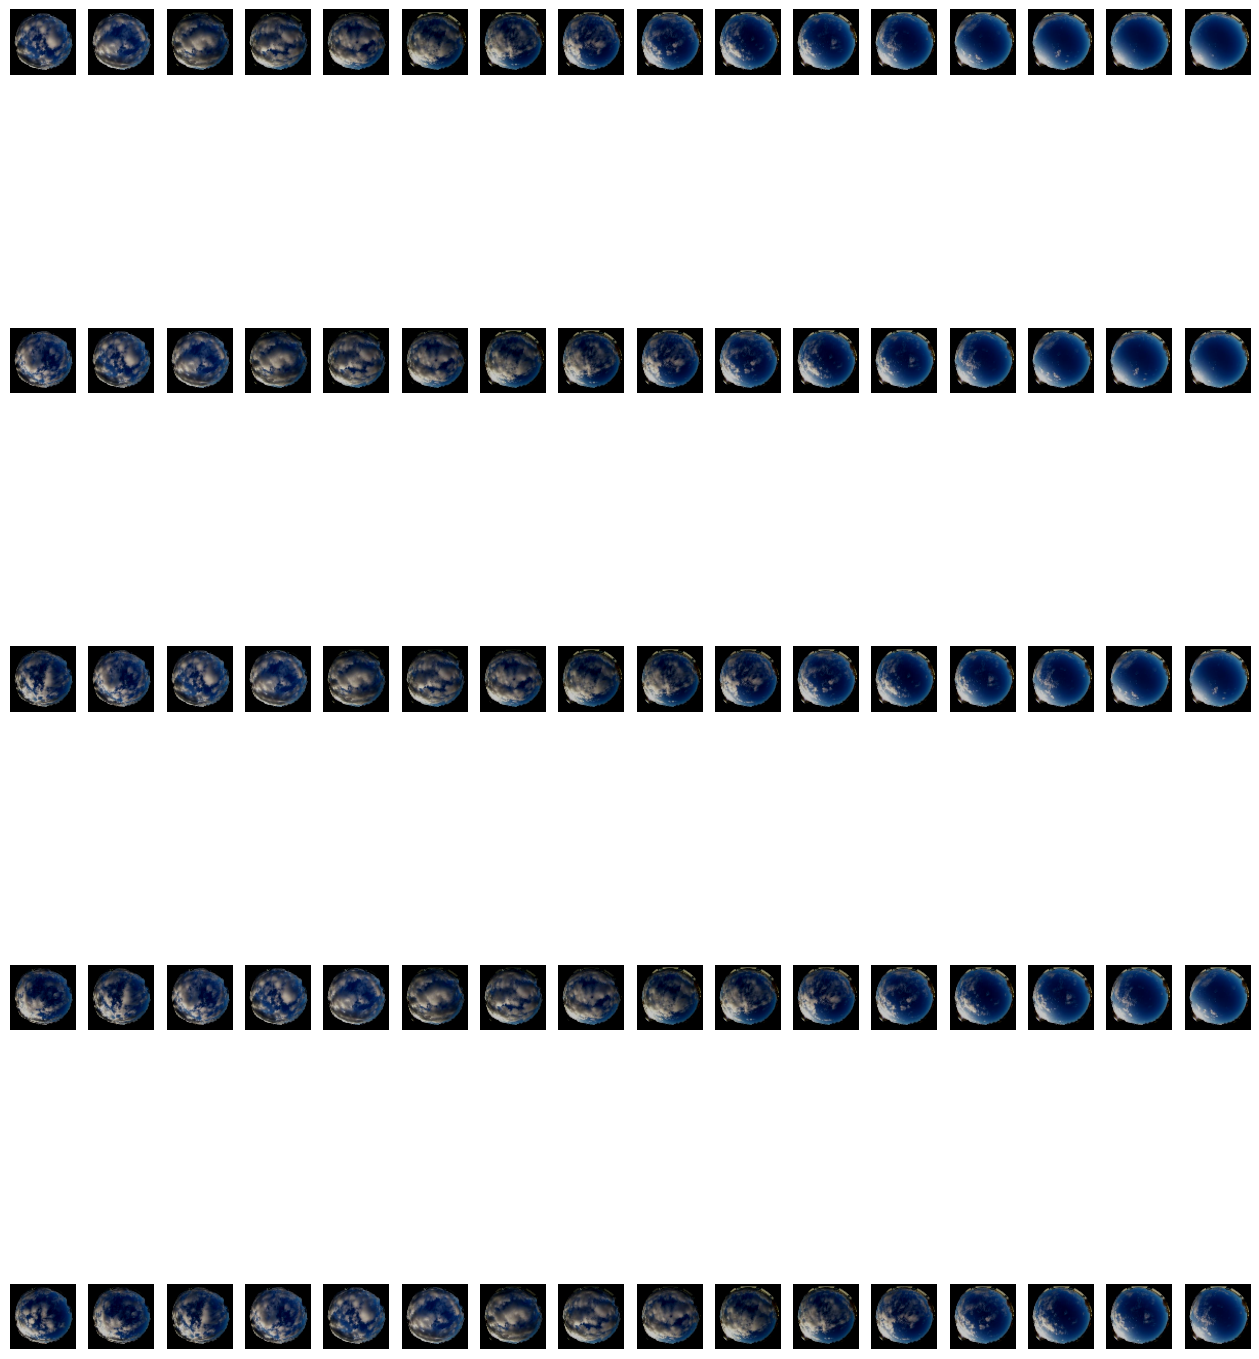

In [ ]:

def plot_image_sequences(image_sequences):
    num_sequences = image_sequences.shape[0]
    sequence_length = image_sequences.shape[1]

    fig, axs = plt.subplots(num_sequences, sequence_length, figsize=(16, 4*num_sequences))

    for i in range(num_sequences):
        for j in range(sequence_length):
            axs[i, j].imshow(image_sequences[i, j])
            axs[i, j].axis('off')

    plt.show()

plot_image_sequences(image_sequens_train[1000:1005])

In [ ]:

images_train = image_sequens_train
images_validation = image_sequens_validation
images_test = image_sequens_test

## 3.4. Auxiliary Data
- Als zusätztlicher Numärischer input für das DL model
- Jeder Datenpunkt soll, die letzten (t-15) PV Power values bis hin zu dem aktuellen (t) value enthalten und die Smart Persistence vorhersage (t+15)

In [ ]:
# Definiere Spezifische Parameter:
"""
# OTH Regensburg
# PV Anlage Parameter
max_solar_irradiance = 135  # Im in W/m^2
effective_panel_area = 1.584*12  # Ae in m^2
panel_elevation = 30  # ϵ
panel_azimuth = 180  # ζ

# Standortkoordinaten
latitude = 49.0001
longitude = 12.0956
altitude = 337 # Meter über dem Meeresspiegel
"""

# Stanford
# PV Anlage Parameter
max_solar_irradiance = 1000  # Im in W/m^2
effective_panel_area = 24.98  # Ae in m^2
panel_elevation = 22.5  # ϵ
panel_azimuth = 195  # ζ

# Standortkoordinaten
latitude = 37.42808
longitude = -122.17023
altitude = 23 # Meter über dem Meeresspiegel


In [ ]:

predictions_train, predictions_validation, predictions_test = smart_persistence_pv_forecast(labels_train, labels_validation, labels_test,
                                                                                            datetime_labels_train, datetime_labels_validation,
                                                                                            datetime_labels_test)



In [ ]:
num_previous_images = 15
images_train, images_validation, images_test, labels_train, labels_validation, labels_test, datetime_train, datetime_validation, datetime_test, datetime_labels_train, datetime_labels_validation, datetime_labels_test, predictions_train, predictions_validation, predictions_test, sequence_labels_train, sequence_labels_validation, sequence_labels_test = create_sequence_arrays(images_train, images_validation, images_test, labels_train, labels_validation, labels_test, datetime_train, datetime_validation, datetime_test, datetime_labels_train, datetime_labels_validation, datetime_labels_test, predictions_train, predictions_validation, predictions_test, num_previous_images=num_previous_images )



In [ ]:
# Erstellen der Auxilary daten als Float32 Stunde,Minute werte (von der Label datetime)
num_previous_images = 15
Aux_Time_train, Aux_Time_validation, Aux_Time_test = extract_hour_minute_combined_arrays(datetime_labels_train, datetime_labels_validation, datetime_labels_test,num_previous_images=num_previous_images)


Shape of args[0]: (139704, 16)
Shape of args[1]: (34893, 16)
Shape of args[2]: (13958, 16)


In [ ]:
# Alles Auf die gleiche Länge bringen
print_shapes_kwargs(
    Aux_Time_train=Aux_Time_train,
    Aux_Time_validation=Aux_Time_validation,
    Aux_Time_test=Aux_Time_test,
    images_train=images_train,
    images_validation=images_validation,
    images_test=images_test,
    labels_train=labels_train,
    labels_validation=labels_validation,
    labels_test=labels_test,
    datetime_train=datetime_train,
    datetime_validation=datetime_validation,
    datetime_test=datetime_test,
    datetime_labels_train=datetime_labels_train,
    datetime_labels_validation=datetime_labels_validation,
    datetime_labels_test=datetime_labels_test,
    predictions_train=predictions_train,
    predictions_validation=predictions_validation,
    predictions_test=predictions_test,
    sequence_labels_train=sequence_labels_train,
    sequence_labels_validation=sequence_labels_validation,
    sequence_labels_test=sequence_labels_test
)

Aux_Time_train, Aux_Time_validation, Aux_Time_test, images_train, images_validation, images_test, labels_train, labels_validation, labels_test, datetime_train, datetime_validation, datetime_test, datetime_labels_train, datetime_labels_validation, datetime_labels_test, predictions_train, predictions_validation, predictions_test, sequence_labels_train, sequence_labels_validation, sequence_labels_test = trim_data_to_min_length(Aux_Time_train=Aux_Time_train,
                          Aux_Time_validation=Aux_Time_validation,
                          Aux_Time_test=Aux_Time_test,
                          images_train=images_train,
                          images_validation=images_validation,
                          images_test=images_test,
                          labels_train=labels_train,
                          labels_validation=labels_validation,
                          labels_test=labels_test,
                          datetime_train=datetime_train,
                          datetime_validation=datetime_validation,
                          datetime_test=datetime_test,
                          datetime_labels_train=datetime_labels_train,
                          datetime_labels_validation=datetime_labels_validation,
                          datetime_labels_test=datetime_labels_test,
                          predictions_train=predictions_train,
                          predictions_validation=predictions_validation,
                          predictions_test=predictions_test,
                          sequence_labels_train=sequence_labels_train,
                          sequence_labels_validation=sequence_labels_validation,
                          sequence_labels_test=sequence_labels_test)
print("------------------------------------- \n After edit:\n")
print_shapes_kwargs(
    Aux_Time_train=Aux_Time_train,
    Aux_Time_validation=Aux_Time_validation,
    Aux_Time_test=Aux_Time_test,
    images_train=images_train,
    images_validation=images_validation,
    images_test=images_test,
    labels_train=labels_train,
    labels_validation=labels_validation,
    labels_test=labels_test,
    datetime_train=datetime_train,
    datetime_validation=datetime_validation,
    datetime_test=datetime_test,
    datetime_labels_train=datetime_labels_train,
    datetime_labels_validation=datetime_labels_validation,
    datetime_labels_test=datetime_labels_test,
    predictions_train=predictions_train,
    predictions_validation=predictions_validation,
    predictions_test=predictions_test,
    sequence_labels_train=sequence_labels_train,
    sequence_labels_validation=sequence_labels_validation,
    sequence_labels_test=sequence_labels_test
)

Variable: Aux_Time_train, Shape/Length: (139704, 16)
Variable: Aux_Time_validation, Shape/Length: (34893, 16)
Variable: Aux_Time_test, Shape/Length: (13958, 16)
Variable: images_train, Shape/Length: (139719, 64, 64, 3)
Variable: images_validation, Shape/Length: (34908, 64, 64, 3)
Variable: images_test, Shape/Length: (13973, 64, 64, 3)
Variable: labels_train, Shape/Length: (139719,)
Variable: labels_validation, Shape/Length: (34908,)
Variable: labels_test, Shape/Length: (13973,)
Variable: datetime_train, Shape/Length: (139719,)
Variable: datetime_validation, Shape/Length: (34908,)
Variable: datetime_test, Shape/Length: (13973,)
Variable: datetime_labels_train, Shape/Length: (139719,)
Variable: datetime_labels_validation, Shape/Length: (34908,)
Variable: datetime_labels_test, Shape/Length: (13973,)
Variable: predictions_train, Shape/Length: N/A
Variable: predictions_validation, Shape/Length: N/A
Variable: predictions_test, Shape/Length: N/A
Variable: sequence_labels_train, Shape/Length: 

In [ ]:
# Alles Speichern!

# Save the created Auxiliary Data
Aux_data_save_path = "preprozessed_data_SKIPPD/Auxiliary_Data_Full"
save_path = os.path.join(BASE_file_path, Aux_data_save_path)
os.makedirs(save_path, exist_ok=True)

save_data_to_pickles_generic(save_path,
                             sequence_labels_train=sequence_labels_train,
                             sequence_labels_validation=sequence_labels_validation,
                             sequence_labels_test=sequence_labels_test)

# Save SPM predictions
save_folder = os.path.join(BASE_file_path,"preprozessed_data_SKIPPD/smart_persistence_data_Full")
save_spm_forcast(predictions_train, predictions_validation, predictions_test, save_folder=save_folder)


# Save Aux Time Data
save_folder = os.path.join(BASE_file_path,"preprozessed_data_SKIPPD/Aux_Time_data_Full_Dataset")
save_data_to_pickles_generic(save_folder,
                             Aux_Time_train=Aux_Time_train,
                             Aux_Time_validation=Aux_Time_validation,
                             Aux_Time_test=Aux_Time_test)


Data saved: /content/drive/My Drive/BA/preprozessed_data_SKIPPD/Auxiliary_Data_Full/sequence_labels_train.pkl
Data saved: /content/drive/My Drive/BA/preprozessed_data_SKIPPD/Auxiliary_Data_Full/sequence_labels_validation.pkl
Data saved: /content/drive/My Drive/BA/preprozessed_data_SKIPPD/Auxiliary_Data_Full/sequence_labels_test.pkl
Data saved: /content/drive/My Drive/BA/preprozessed_data_SKIPPD/Aux_Time_data_Full_Dataset/Aux_Time_train.pkl
Data saved: /content/drive/My Drive/BA/preprozessed_data_SKIPPD/Aux_Time_data_Full_Dataset/Aux_Time_validation.pkl
Data saved: /content/drive/My Drive/BA/preprozessed_data_SKIPPD/Aux_Time_data_Full_Dataset/Aux_Time_test.pkl


# 4. Datensatz Darstellen und Analysieren


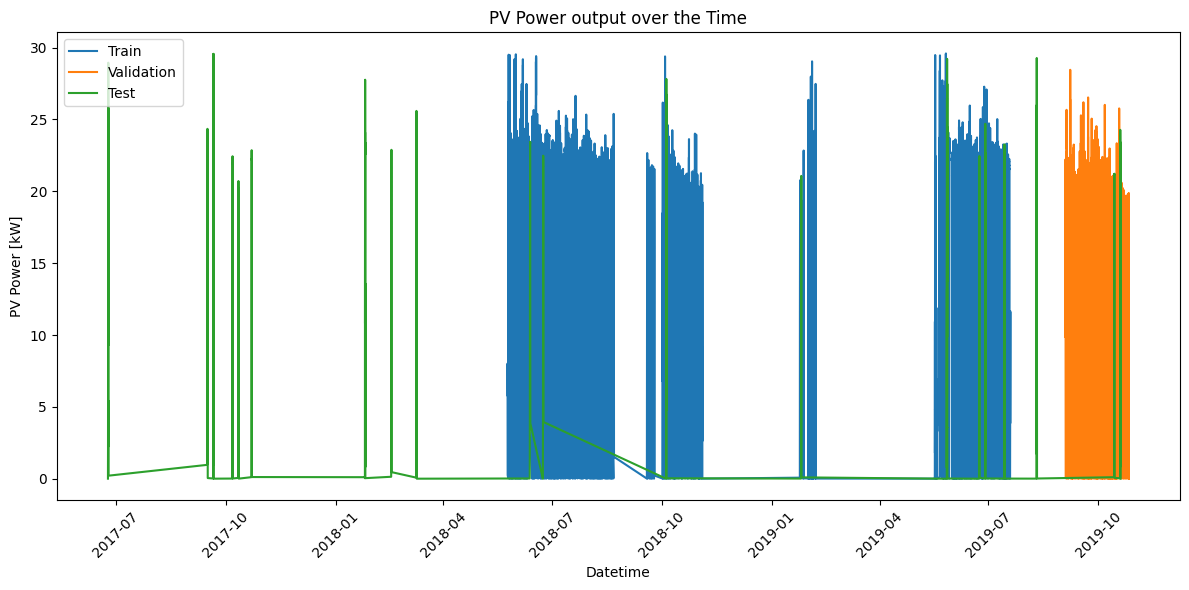

In [ ]:
plot_labels_by_time(labels_train, labels_validation, labels_test,
                        datetime_labels_train, datetime_labels_validation, datetime_labels_test,
                    )

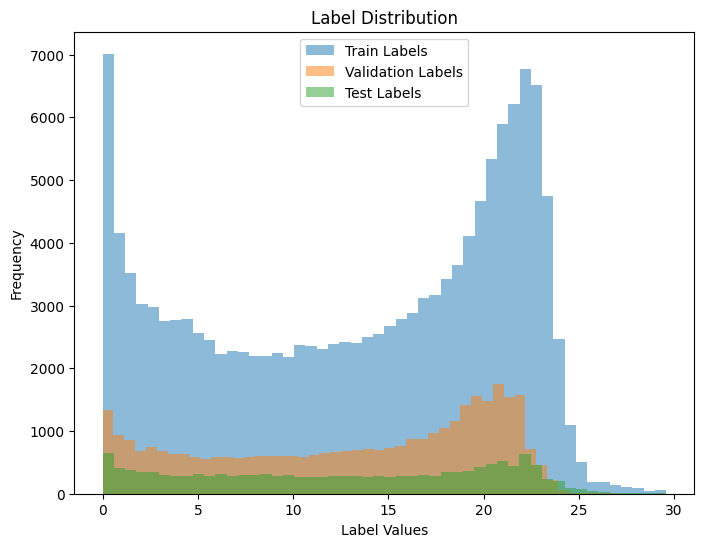

In [ ]:
plot_label_distribution(labels_train, labels_validation, labels_test)

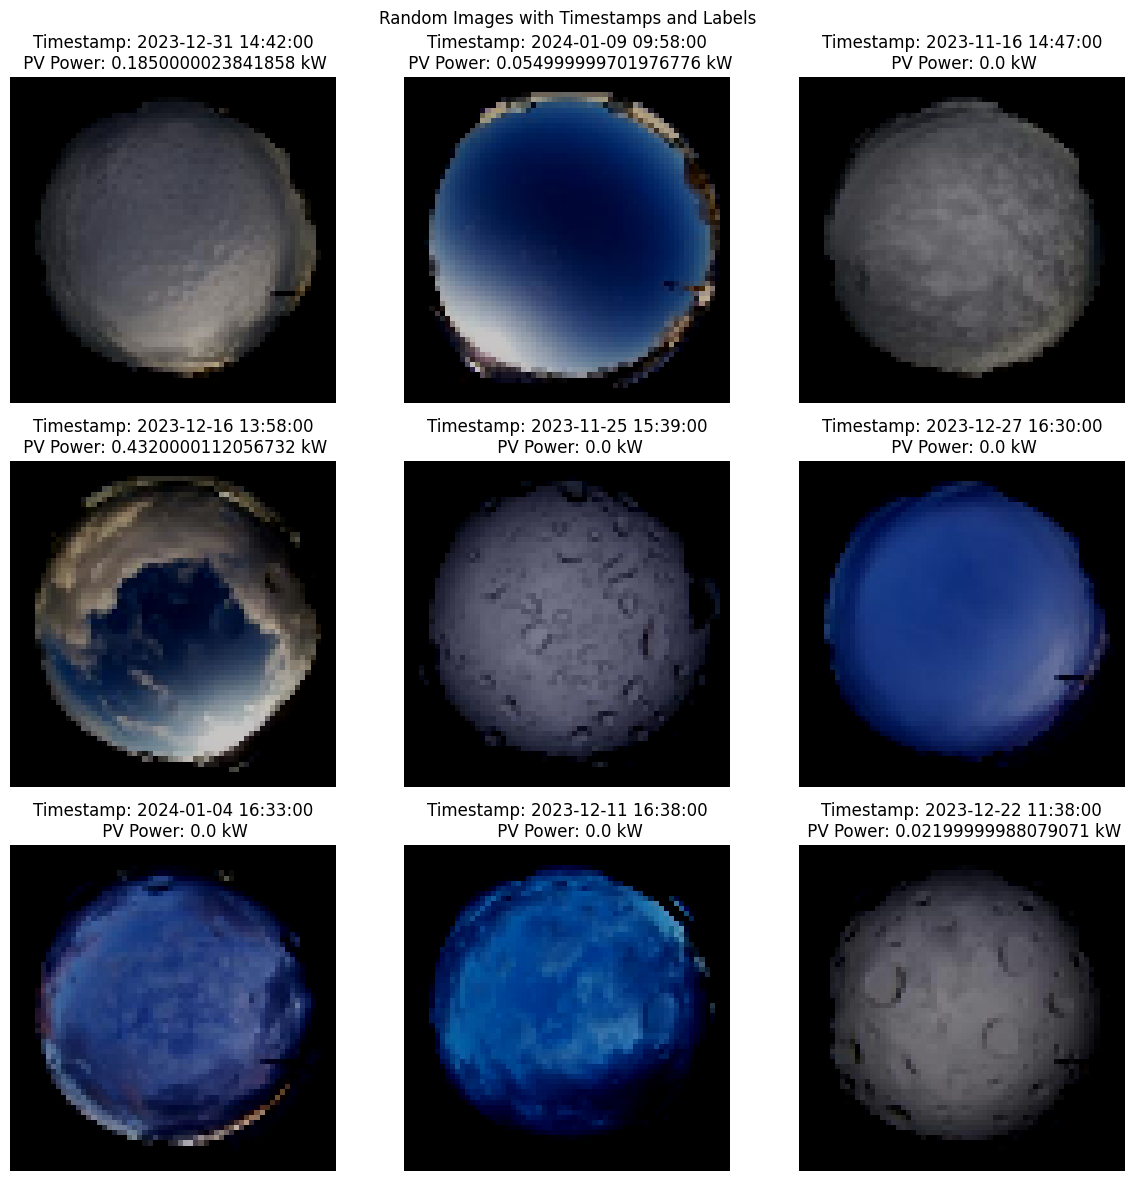

In [ ]:
plot_random_images_with_labels(images_train, labels_train, datetime_train, num_images=9)

# 5. Datensatz Schpeichern

In [ ]:
# ANPASSEN FALLS NÖTIG!

#save_folder = os.path.join(BASE_file_path, "preprozessed_data/RGB_data_Normalized")
#save_folder = os.path.join(BASE_file_path, "preprozessed_data/RGB_zero_centerd_and_Normalized_data")
#save_folder = os.path.join(BASE_file_path, "preprozessed_data/Augmented_data")
#save_folder = os.path.join(BASE_file_path, "preprozessed_data/Greyscale_data")

save_folder = os.path.join(BASE_file_path, "preprozessed_data_SKIPPD/RGB_data_Normalized_Centerd_64_64_Full_dataset_Full_Testset")

In [ ]:
save_data_by_category(images_train, images_validation, images_test,
                      labels_train, labels_validation, labels_test,
                      datetime_train, datetime_validation, datetime_test,
                      datetime_labels_train, datetime_labels_validation, datetime_labels_test,
                      save_folder)

Data saved in Train, Validation, and Test data folders in /content/drive/My Drive/BA/preprozessed_data/Day_Split_70_10_20/RGB_data_Normalized_Centerd_64_64_Full_dataset_Full_Testset


# Load SKIPPD Dataset
quelle: https://github.com/yuhao-nie/Stanford-solar-forecasting-dataset?tab=readme-ov-file

In [ ]:
def load_data_from_path(data_path):
    # Öffne die HDF5-Datei
    hdf5_path = f"{data_path}/2017_2019_images_pv_processed.hdf5"
    with h5py.File(hdf5_path, 'r') as hdf_file:
        images_trainval = hdf_file['trainval'][ "images_log"][:]
        images_test_log = hdf_file['test'][ "images_log"][:]
        pv_trainval =  hdf_file['trainval'][ "pv_log"][:]
        pv_test_log =  hdf_file['test'][ "pv_log"][:]

    # Lade die anderen Dateien
    times_trainval = np.load(f"{data_path}/times_trainval.npy", allow_pickle=True)
    times_test = np.load(f"{data_path}/times_test.npy", allow_pickle=True)

    # Konvertiere die Slicing-Indices zu Ganzzahlen
    trainval_split_index = int(len(images_trainval) * 0.8)

    images_train = images_trainval[:trainval_split_index]
    images_validation = images_trainval[trainval_split_index:]
    images_test = images_test_log

    labels_train = pv_trainval[:trainval_split_index]
    labels_validation = pv_trainval[trainval_split_index:]
    labels_test = pv_test_log

    datetime_train = times_trainval[:trainval_split_index]
    datetime_validation = times_trainval[trainval_split_index:]
    datetime_test = times_test

    datetime_labels_train = datetime_train
    datetime_labels_validation = datetime_validation
    datetime_labels_test = datetime_test

    print_shapes(images_train=images_train,
             images_validation=images_validation,
             images_test=images_test,
             labels_train=labels_train,
             labels_validation=labels_validation,
             labels_test=labels_test,
             datetime_train=datetime_train,
             datetime_validation=datetime_validation,
             datetime_test=datetime_test,
             datetime_labels_train=datetime_labels_train,
             datetime_labels_validation=datetime_labels_validation,
             datetime_labels_test=datetime_labels_test)

    return (images_train, images_validation, images_test,
            labels_train, labels_validation, labels_test,
            datetime_train, datetime_validation, datetime_test,
            datetime_labels_train, datetime_labels_validation, datetime_labels_test)



In [ ]:

data_path = os.path.join(BASE_file_path,"SKIPPED_Dataset")

(images_train, images_validation, images_test,
 labels_train, labels_validation, labels_test,
 datetime_train, datetime_validation, datetime_test,
 datetime_labels_train, datetime_labels_validation, datetime_labels_test) = load_data_from_path(data_path)

Trainingsdaten:
Bilder: (279497, 64, 64, 3)
Labels: (279497,)
Datetime: (279497,)
Datetime Labels: (279497,)

Validierungsdaten:
Bilder: (69875, 64, 64, 3)
Labels: (69875,)
Datetime: (69875,)
Datetime Labels: (69875,)

Testdaten:
Bilder: (14003, 64, 64, 3)
Labels: (14003,)
Datetime: (14003,)
Datetime Labels: (14003,)


In [ ]:
images_train = images_train[len(images_train)//2:]
images_validation = images_validation[len(images_validation)//2:]
images_test = images_test[:]

labels_train = labels_train[len(labels_train)//2:]
labels_validation = labels_validation[len(labels_validation)//2:]
labels_test = labels_test[:]

datetime_train = datetime_train[len(datetime_train)//2:]
datetime_validation = datetime_validation[len(datetime_validation)//2:]
datetime_test = datetime_test[:]

datetime_labels_train = datetime_labels_train[len(datetime_labels_train)//2:]
datetime_labels_validation = datetime_labels_validation[len(datetime_labels_validation)//2:]
datetime_labels_test=datetime_labels_test[:]

print_shapes(images_train=images_train,
             images_validation=images_validation,
             images_test=images_test,
             labels_train=labels_train,
             labels_validation=labels_validation,
             labels_test=labels_test,
             datetime_train=datetime_train,
             datetime_validation=datetime_validation,
             datetime_test=datetime_test,
             datetime_labels_train=datetime_labels_train,
             datetime_labels_validation=datetime_labels_validation,
             datetime_labels_test=datetime_labels_test)


Trainingsdaten:
Bilder: (139749, 64, 64, 3)
Labels: (139749,)
Datetime: (139749,)
Datetime Labels: (139749,)

Validierungsdaten:
Bilder: (34938, 64, 64, 3)
Labels: (34938,)
Datetime: (34938,)
Datetime Labels: (34938,)

Testdaten:
Bilder: (14003, 64, 64, 3)
Labels: (14003,)
Datetime: (14003,)
Datetime Labels: (14003,)


In [ ]:
# preprozess Data for Prediction 15 min into the future
images_train = images_train[:-15]
images_validation = images_validation[:-15]
images_test = images_test[:-15]

labels_train = labels_train[15:]
labels_validation = labels_validation[15:]
labels_test = labels_test[15:]

datetime_train = datetime_train[:-15]
datetime_validation = datetime_validation[:-15]
datetime_test = datetime_test[:-15]

datetime_labels_train = datetime_labels_train[15:]
datetime_labels_validation = datetime_labels_validation[15:]
datetime_labels_test=datetime_labels_test[15:]

In [ ]:
print_shapes(images_train=images_train,
             images_validation=images_validation,
             images_test=images_test,
             labels_train=labels_train,
             labels_validation=labels_validation,
             labels_test=labels_test,
             datetime_train=datetime_train,
             datetime_validation=datetime_validation,
             datetime_test=datetime_test,
             datetime_labels_train=datetime_labels_train,
             datetime_labels_validation=datetime_labels_validation,
             datetime_labels_test=datetime_labels_test)

Trainingsdaten:
Bilder: (139734, 64, 64, 3)
Labels: (139734,)
Datetime: (139734,)
Datetime Labels: (139734,)

Validierungsdaten:
Bilder: (34923, 64, 64, 3)
Labels: (34923,)
Datetime: (34923,)
Datetime Labels: (34923,)

Testdaten:
Bilder: (13988, 64, 64, 3)
Labels: (13988,)
Datetime: (13988,)
Datetime Labels: (13988,)


In [ ]:
# Normalisieren und centern
Normalisierung=True
zero_centering=True

if Normalisierung:
        # Normalisierung der Bilder durch Teilung durch 255
    images_train = images_train.astype(np.float32) / 255.0
    images_validation = images_validation.astype(np.float32) / 255.0
    images_test = images_test.astype(np.float32) / 255.0

if zero_centering:
        # Zero-Centering der Bilder
    images_train -= np.mean(images_train, axis=(0, 1, 2), keepdims=True)
    images_validation -= np.mean(images_validation, axis=(0, 1, 2), keepdims=True)
    images_test -= np.mean(images_test, axis=(0, 1, 2), keepdims=True)

In [ ]:
save_folder = os.path.join(BASE_file_path, "preprozessed_data_SKIPPD/RGB_data_Normalized_Centerd_64_64_Full_dataset_Full_Testset")

In [ ]:
save_data_by_category(images_train, images_validation, images_test,
                      labels_train, labels_validation, labels_test,
                      datetime_train, datetime_validation, datetime_test,
                      datetime_labels_train, datetime_labels_validation, datetime_labels_test,
                      save_folder)

Data saved in Train, Validation, and Test data folders in /content/drive/My Drive/BA/preprozessed_data_SKIPPD/RGB_data_Normalized_Centerd_64_64_Full_dataset_Full_Testset


# TEST


In [ ]:

def load_preprocessed_data(parent_folder_path, small_dataset=True):
    """
    Lädt Daten aus Pickle-Dateien in einen Datensatz.

    Parameters:
    parent_folder_path (str): Der Pfad zum übergeordneten Ordner, der Unterordner mit Pickle-Dateien enthält.
    small_dataset (bool): True, wenn nur die Hälfte des Datensatzes geladen werden soll, andernfalls False.

    Returns:
    dict: Ein Dictionary mit den geladenen Daten.
    """
    data_set = {}

    # Durchsuche alle Unterordner des übergeordneten Ordners
    subfolders = [f for f in os.listdir(parent_folder_path) if os.path.isdir(os.path.join(parent_folder_path, f))]

    if subfolders:
        for folder_name in subfolders:
            folder_path = os.path.join(parent_folder_path, folder_name)
            load_data_from_folder(data_set, folder_path, small_dataset)
    else:
        # Wenn keine Unterordner vorhanden sind, lade Pickle-Dateien direkt aus dem Hauptordner
        load_data_from_folder(data_set, parent_folder_path, small_dataset)

    return data_set

def load_data_from_folder(data_set, folder_path, small_dataset=True):
    """
    Lädt Daten aus Pickle-Dateien in einen Datensatz.

    Parameters:
    data_set (dict): Das Dictionary, dem die geladenen Daten hinzugefügt werden.
    folder_path (str): Der Pfad zum Ordner, der Pickle-Dateien enthält.
    small_dataset (bool): True, wenn nur die Hälfte des Datensatzes geladen werden soll, andernfalls False.

    Returns:
    None
    """
    # Durchsuche den Ordner nach Pickle-Dateien
    for filename in os.listdir(folder_path):
        if filename.endswith(".pkl"):
            var_name = os.path.splitext(filename)[0]  # Entferne die Dateiendung
            file_path = os.path.join(folder_path, filename)

            # Lade die Pickle-Datei und füge sie zum Daten-Dict hinzu
            with open(file_path, 'rb') as file:
                loaded_data = pickle.load(file)

                # Reduziere die Datenmenge, wenn small_dataset True ist
                if small_dataset:
                    loaded_data = loaded_data[:len(loaded_data)//2]

                data_set[var_name] = loaded_data



In [ ]:
# Load preprozessed Train-/ Testset
folder= os.path.join(BASE_file_path,"preprozessed_data/Day_Split_70_15_15/RGB_data_Normalized_Centerd_64_64_Full_dataset")
data_set = load_preprocessed_data(folder, small_dataset=False)

folder= os.path.join(BASE_file_path,"preprozessed_data/Day_Split_70_15_15/Auxiliary_Data")
aux_data = load_preprocessed_data(folder, small_dataset=False)


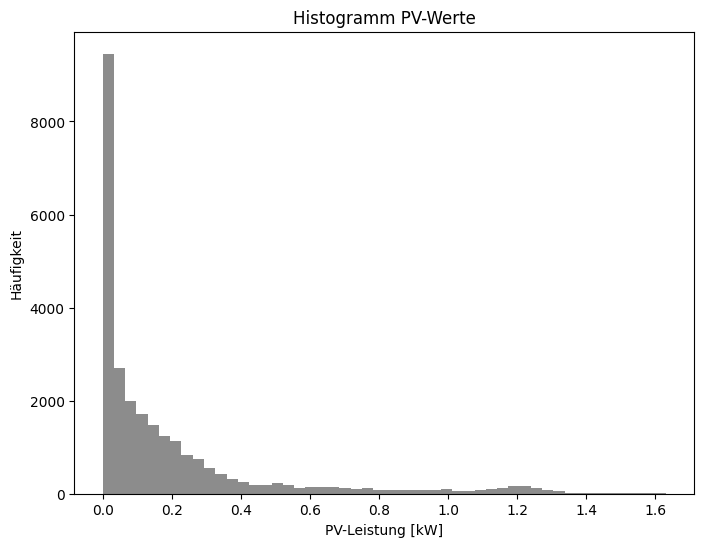

In [ ]:
temp = []
temp.extend(data_set["labels_train"])
temp.extend(data_set["labels_validation"])
temp.extend(data_set["labels_test"])

plt.figure(figsize=(8, 6))
plt.hist(temp, bins=50, alpha=0.9, color='grey')
plt.xlabel('PV-Leistung [kW]')
plt.ylabel('Häufigkeit')
plt.title('Histogramm PV-Werte')
plt.show()

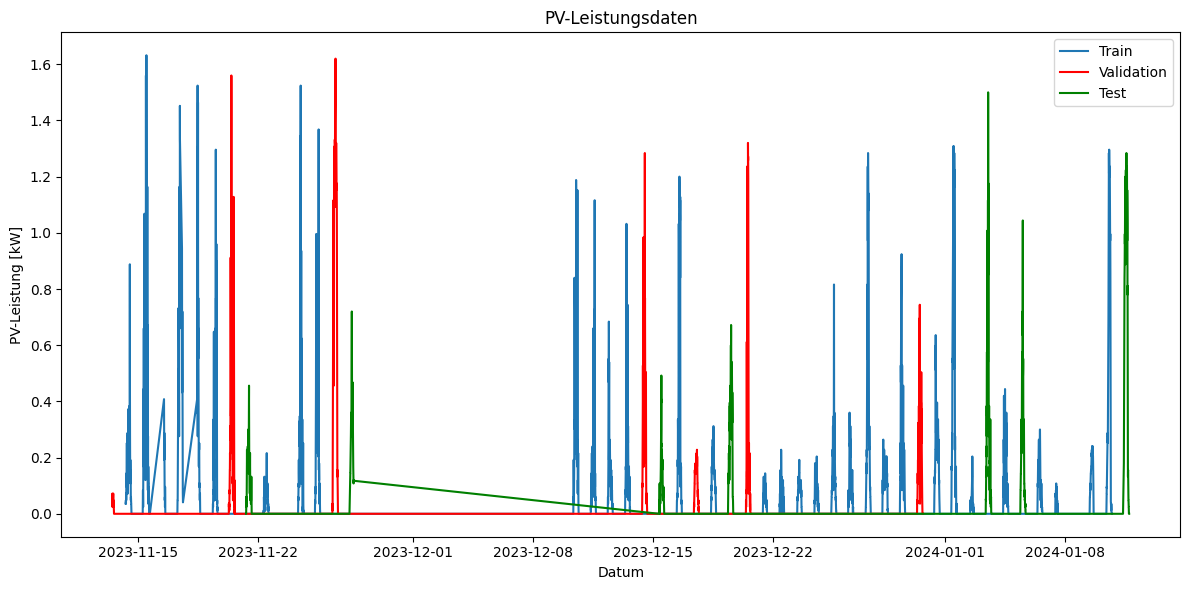

In [ ]:
plot_labels_by_time(data_set["labels_train"], data_set["labels_validation"], data_set["labels_test"],
                        data_set["datetime_labels_train"], data_set["datetime_labels_validation"], data_set["datetime_labels_test"],
                    )